In [ ]:
"""

TODO:

save posts/comments sorted by ticker, will allow for easier handling later

however: when deriving sentiment, we might need to consider the context (ie, ticker)
for "multi-ticker" posts. How do we do this?

what could be done otherwise: simply drop "multi-ticker" posts, but then this has
to be mentioned (and maybe motivated)





"""

### **Financial Text Pre-Processing**

In [ ]:
# Data retrieved from and credited to: https://github.com/ArthurHeitmann/arctic_shift

In [2]:
!pip install pandas_market_calendars

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.4/131.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: toolz
    Found existing installation: toolz 0.12.1
    Uninstalling toolz-0.12.1:
      Successfully uninstalled toolz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.5.0 requires toolz<1,>=0.11, but you have toolz 1.1.0 which is incompatible.


In [3]:
# imports
import pyarrow as pa
import pyarrow.parquet as pq
import json
import re
from collections import Counter
from datetime import datetime, timezone, time
from json import JSONDecodeError
import duckdb
import yfinance as yf
import numpy as np
import pandas as pd
import pandas_market_calendars as pmcal
import pytz
import os

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from tqdm.notebook import tqdm

from google.colab import drive

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}.")

Running on cuda.


In [5]:
from google.colab import drive
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
import sys
if IN_COLAB:
    drive.mount('/content/drive')
    SAVE_PATH = "/content/drive/MyDrive/KTH/Master, 4-5/ÅK2/Degree Project/Data/"
    sys.path.append(SAVE_PATH)
else: SAVE_PATH = "../data"

Mounted at /content/drive


In [6]:
PARQ_BATCH_SIZE = 50_000 # For smoother data storage in pre-processing

START_DATE = "2025-12-01" # Change later to an earlier one for more data.
END_DATE = "2026-02-03"

# Get the trading days and market opening hours for the NYSE
NYSE = pmcal.get_calendar("NYSE")
SCHEDULE = NYSE.schedule(
    start_date = START_DATE,
    end_date = END_DATE
)
TRADING_DAYS = pd.to_datetime(SCHEDULE.index.date)

NY_TZ = pytz.timezone("America/New_York")
MARKET_CLOSE = time(16, 0)

In [7]:
# IMPORTANT! Should I also include the full names here? If someone mentions the
# stock by the company name instead of just the ticker.
# Consideration that follows: we dont have to count appearances, maybe not for
# the tickers as well?

# ALSO: maybe add Nvidia? A broadly discussed stock

TICKERS = ["AAPL", "GOOGL", "MSFT", "META", "PLTR", "TSLA"] # maybe GME also?

SUBREDDITS = ["r_valueinvesting",
              "r_investing",
              "r_wallstreetbets",
              "r_stocks"
              ]

POST_TYPES = ["_posts", "_comments"]

In [16]:
def move_trading_day(date, trading_days):
    date = pd.to_datetime(date).date()
    future_days = trading_days[trading_days > pd.Timestamp(date)]
    return future_days[0].date()

In [17]:
def raw_to_parquet(sub, pt, batch_size, save_path, trading_days, extension_type=".jsonl"):
    data = []
    file_name = f"{sub}{pt}"
    pattern = re.compile(r"(?<![A-Z0-9])\$?(" + "|".join(TICKERS) + r")(?![A-Z0-9])", re.IGNORECASE)
    try:
        with open(file_name + extension_type, "r", encoding="utf-8") as f:
            bad_lines = 0
            total_lines = 0
            for i, line in enumerate(f, start=1):
                # Make sure json loading works
                try:
                    total_lines += 1
                    line = json.loads(line)
                except JSONDecodeError as e:
                    print("Broken line index:", i)
                    print("Error:", e)
                    # print("Line:", line)
                    bad_lines += 1
                    continue

                # Make sure the post includes at least one of the tickers of interest.
                t1 = line.get("title") or ""
                t2 = line.get("selftext") or ""

                text = f"{t1} {t2}"

                ticker_matches = pattern.findall(text)
                if not ticker_matches:
                    continue

                # Move posts made outside trading days/hours to the next trading day.
                utc_formatted = datetime.fromtimestamp(line["created_utc"], tz=timezone.utc)
                ny_dt = utc_formatted.astimezone(NY_TZ)

                date = ny_dt.date()

                if pd.Timestamp(date) not in trading_days:
                    date = move_trading_day(date, trading_days)

                if utc_formatted.time() >= MARKET_CLOSE:
                    date = move_trading_day(date, trading_days)

                tickers = sorted({m.upper() for m in ticker_matches})
                ticker_counts = Counter(m.upper() for m in ticker_matches)

                # we allow for duplicate data because one post might mention multiple stocks
                for ticker in tickers:
                    data.append({
                        "id": line["id"],
                        "author": line["author"],
                        "created_utc": line["created_utc"],
                        "year": date.year,
                        "month": date.month,
                        "day": date.day,
                        "trading_date": str(date),
                        "score": line["score"],
                        "title": line["title"],
                        "text": line["selftext"],
                        "ticker": ticker,
                        "ticker_counts": ticker_counts
                        })

                if len(data) >= batch_size:
                    # partition the data into batches when writing to parquet for RAM bounding
                    table = pa.Table.from_pylist(data)
                    pq.write_to_dataset(
                        table,
                        root_path=os.path.join(save_path, sub),
                        partition_cols=["ticker", "year", "month"]
                    )
                    data.clear()

        # dump the remaining data, if there is any
        if len(data) > 0:
            print(f"Remaining cols: {len(data)}")
            table = pa.Table.from_pylist(data)
            pq.write_to_dataset(
                table,
                root_path=os.path.join(save_path, sub),
                partition_cols=["ticker", "year", "month"] # we could also partition by ticker ??
            )
            data.clear()
    except OSError:
        print(f"Could not find the file {file_name}. No files created.")
        return

    print(f"Total lines: {total_lines}, total corrupt lines: {bad_lines}")
    print(f"Percentage of corrupt lines: {0 if total_lines == 0 else round(bad_lines/total_lines, 2) * 100}%")
    print(f"Data sucessfully saved to {save_path}{sub}.")

In [18]:
for sub in SUBREDDITS:
    for pt in POST_TYPES:
        # for easier formatting later on
        # aggregates both posts and comments into the same file
        raw_to_parquet(sub, pt, PARQ_BATCH_SIZE, SAVE_PATH, TRADING_DAYS)

Could not find the file r_valueinvesting_posts. No files created.
Could not find the file r_valueinvesting_comments. No files created.
Could not find the file r_investing_posts. No files created.
Could not find the file r_investing_comments. No files created.
Could not find the file r_wallstreetbets_posts. No files created.
Could not find the file r_wallstreetbets_comments. No files created.
Could not find the file r_stocks_posts. No files created.
Could not find the file r_stocks_comments. No files created.


In [8]:
# Example query for retrieving processed data.
# data_path = os.path.join(SAVE_PATH, 'r_valueinvesting/**/*.parquet')
# print(data_path)
# posts_data = duckdb.query(f"""
#     SELECT *
#     FROM read_parquet('{data_path}')
#     WHERE 'AAPL' IN tickers
#     AND year = 2026
# """).df()
# posts_data

### **Time-Series Data Pre-Processing**

In [9]:
# Time-series data retrieved from and credited to https://finance.yahoo.com (API)

In [10]:
def raw_to_timeseries(ticker, start_date, end_date):
    ticker_data = yf.Ticker(ticker)
    ticker_history = ticker_data.history(start=start_date, end=end_date)
    close_prices = ticker_history[["Close"]].reset_index().rename(columns={"Date": "date", "Close": "close"})
    close_prices["log_return"] = np.log(close_prices["close"] / close_prices["close"].shift(1))
    close_prices.loc[0, "log_return"] = 0
    close_prices["date"] = close_prices["date"].dt.date
    # print(close_prices)
    return close_prices

In [11]:
time_series_dict = {}
for ticker in TICKERS:
    time_series_dict[ticker] = raw_to_timeseries(ticker, START_DATE, END_DATE)

In [ ]:
# time_series_dict

What we have now: parquet files with text, dates etc as well as time-series data.
  
What we need:
1. Sentiment connected to the text data.
2. Handle days when the market is closed (to next trading day). **DONE**
3. Align sentiment and price (log_return) data.

### **Retrieve sentiment from posts and comments**

In [ ]:
# Use FinBERT (GIVE CREDITS HERE)

In [45]:
data_path = os.path.join(SAVE_PATH, 'r_valueinvesting/**/*.parquet')
posts_data = duckdb.query(f"""
    SELECT *
    FROM read_parquet('{data_path}')
""").df()

posts_data["full_text"] = posts_data["title"] + " " + posts_data["text"]

In [36]:
MODEL_TYPE = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_TYPE)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_TYPE)
model.to(device).eval()

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: ProsusAI/finbert
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [37]:
def text_to_sentiment(texts_list, batch_size=16, max_length=384):
    labels = []
    confs = []
    probs_all = []

    tqdm_iterable = [texts_list[i:i+batch_size] for i in range(0, len(texts_list), batch_size)]

    print(f"A total of {len(tqdm_iterable)} batches to process...")

    # return 1, 2, 3

    for batch in tqdm(tqdm_iterable):
        # batch = texts_list[i:i+batch_size] # extract a batch from the texts list

        # Tokenize the input
        inputs = tokenizer(
            batch,
            padding = True,
            truncation = True,
            max_length = max_length, # max length, FinBERT has a token limit
            return_tensors = "pt"
        ).to(device)

        with torch.no_grad():
            logits = model(**inputs).logits
            probs = softmax(logits, dim=1)

        conf = probs.max(dim=1).values
        predicted_value = probs.argmax(dim=1)

        labels.extend(predicted_value.cpu().tolist())
        confs.extend(conf.cpu().tolist())
        probs_all.append(probs.cpu().numpy())

    # print(probs_all.shape)
    probs_all = np.vstack(probs_all)
    # print(probs_all.shape)
    return np.array(labels), np.array(confs), probs_all


In [38]:
fin_texts = posts_data["full_text"].to_list()
# print(fin_texts)
labels, confs, probs = text_to_sentiment(fin_texts)

A total of 18 batches to process...


  0%|          | 0/18 [00:00<?, ?it/s]

In [46]:
id2label_dict = model.config.id2label
posts_data["sentiment_label"] = [id2label_dict[int(x)].lower() for x in labels]
posts_data["sentiment_conf"] = confs
posts_data["p_negative"] = probs[:, 0]
posts_data["p_neutral"] = probs[:, 1]
posts_data["p_positive"] = probs[:, 2]
posts_data["sentiment_value"] = posts_data["p_positive"] - posts_data["p_negative"] # assumption: neutral does not hold much information (?)

In [48]:
posts_data.columns

Index(['id', 'author', 'created_utc', 'day', 'trading_date', 'score', 'title',
       'text', 'tickers', 'ticker_counts', 'month', 'year', 'full_text',
       'sentiment_label', 'sentiment_conf', 'p_negative', 'p_neutral',
       'p_positive', 'sentiment_value'],
      dtype='object')

In [49]:
# we do not need the title and text anymore since this data is already processed
posts_data = posts_data.drop(columns=["title", "text"])

In [50]:
posts_data.columns

Index(['id', 'author', 'created_utc', 'day', 'trading_date', 'score',
       'tickers', 'ticker_counts', 'month', 'year', 'full_text',
       'sentiment_label', 'sentiment_conf', 'p_negative', 'p_neutral',
       'p_positive', 'sentiment_value'],
      dtype='object')

In [51]:
# dump data into a parquet file
posts_data.to_parquet(
    path=os.path.join(SAVE_PATH, "sentiment_parquet"),
    partition_cols=["year", "month"]
)

In [59]:
# alternatively, load data from parquet file
# posts_data = pd.read_parquet(os.path.join(SAVE_PATH, "sentiment_parquet"), engine="pyarrow")

In [56]:
posts_data

,id,author,created_utc,day,trading_date,score,tickers,ticker_counts,full_text,sentiment_label,sentiment_conf,p_negative,p_neutral,p_positive,sentiment_value,year,month
0,1pb1fn9,Inner-Lavishness1909,1764557795,1,2025-12-01,0,[META],"{'AAPL': None, 'GOOGL': None, 'META': 2.0, 'MS...",Broadcom - Nvidia's toughest rival? In a recen...,neutral,0.923499,0.038567,0.037935,0.923499,0.884932,2025,12
1,1pb284h,P0piah,1764560021,1,2025-12-01,0,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1.0, 'MS...","Market sudden silence on META, this might be a...",neutral,0.854367,0.053334,0.092299,0.854367,0.801034,2025,12
2,1pbd72e,humand09,1764596836,1,2025-12-01,35,[META],"{'AAPL': None, 'GOOGL': None, 'META': 5.0, 'MS...",Not sure if Meta still counts as a value play ...,negative,0.691623,0.073105,0.691623,0.235272,0.162167,2025,12
3,1pbgprq,BeatingTheTide,1764605234,2,2025-12-02,869,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1.0, 'MS...",Energy Stocks Are Still Cheap… and Nobody Seem...,neutral,0.885189,0.066770,0.048041,0.885189,0.818419,2025,12
4,1pbv40h,ilikemisosoupers,1764638562,1,2025-12-01,1,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1.0, 'MS...",Thoughts on META going into 2026? [removed],neutral,0.916381,0.026478,0.057141,0.916381,0.889903,2025,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1qtc12x,Clear-Monk7794,1769982805,3,2026-02-03,1,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1.0, 'MS...",META Stock Forecast 2030: Scenario Analysis of...,neutral,0.939916,0.020736,0.039349,0.939916,0.919180,2026,2
275,1qtpyy4,GainifyAI,1770022535,2,2026-02-02,35,[PLTR],"{'AAPL': None, 'GOOGL': None, 'META': None, 'M...",Is $PLTR the most expensive large cap in the m...,neutral,0.524289,0.450591,0.025119,0.524289,0.073698,2026,2
276,1qu1n1g,ijasonyang4422,1770053650,3,2026-02-03,7,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1.0, 'MS...",when does ceg start looking attractive? AI dat...,neutral,0.632444,0.187921,0.179634,0.632444,0.444523,2026,2
277,1qu8ogw,OnTheStreetwithLou,1770068549,3,2026-02-03,6,[META],"{'AAPL': None, 'GOOGL': None, 'META': 10.0, 'M...",Why Meta is Already a Clear & Early Winner wit...,positive,0.932246,0.932246,0.012860,0.054894,-0.877351,2026,2


<Axes: >

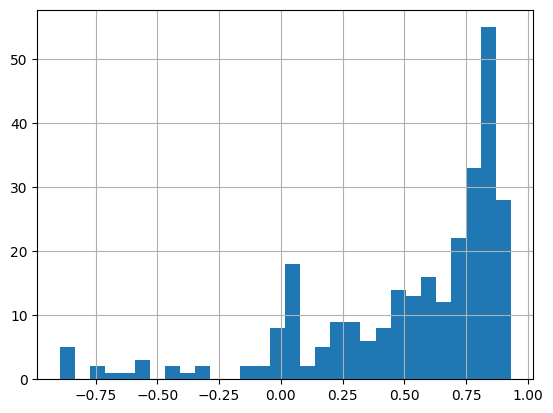

In [57]:
# plot the sentiment distribution, higher => more positive and vice versa
posts_data["sentiment_value"].hist(bins=30)

Thought:

I want to weight the posts by the score, then sum the total amount of posts for a certain date to the "total" sentiment for that date (although this probably should be implemented when aligning the sentiment to logret data and not now). Should be done by the following formula, and "score" is the total number of upvotes - downvotes for a post/comment:

$\sum \frac{w_i s_i}{w_i}$ where $w_i = max(1, log(1+score))$.

Important consideration: right now, we only keep posts or comments that explicitly mentions a ticker, and we might disregard any comments under a post discussing a certain ticker that does not explicitly mention it. E.g.: "I really believe in the leadership of this company and I think they will produce strong numbers in the future" [obvious positive sentiment] under a post discussing "AAPL". FIX: this can be fixed by finding the parent ID of a comment to see where it links. Considerations here might be that we get higer ambiguity in these comments that does not explicitly mention a ticker, but FinBERT should hopefully labels these as "neutral".

### **Align sentiment data with log-return time-series data**

In [123]:

data_path = os.path.join(SAVE_PATH, 'sentiment_parquet/**/*.parquet')
posts_data = duckdb.query(f"""
    SELECT *
    FROM read_parquet('{data_path}')
""").df()

    # WHERE AAPL in tickers # can be used to select a specific ticker


# time_series_dict[ticker]

In [112]:
posts_data

,id,author,created_utc,day,trading_date,score,tickers,ticker_counts,full_text,sentiment_label,sentiment_conf,p_negative,p_neutral,p_positive,sentiment_value,month,year
0,1pb1fn9,Inner-Lavishness1909,1764557795,1,2025-12-01,0,[META],"{'AAPL': None, 'GOOGL': None, 'META': 2, 'MSFT...",Broadcom - Nvidia's toughest rival? In a recen...,neutral,0.923499,0.038567,0.037935,0.923499,0.884932,12,2025
1,1pb284h,P0piah,1764560021,1,2025-12-01,0,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1, 'MSFT...","Market sudden silence on META, this might be a...",neutral,0.854367,0.053334,0.092299,0.854367,0.801034,12,2025
2,1pbd72e,humand09,1764596836,1,2025-12-01,35,[META],"{'AAPL': None, 'GOOGL': None, 'META': 5, 'MSFT...",Not sure if Meta still counts as a value play ...,negative,0.691623,0.073105,0.691623,0.235272,0.162167,12,2025
3,1pbgprq,BeatingTheTide,1764605234,2,2025-12-02,869,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1, 'MSFT...",Energy Stocks Are Still Cheap… and Nobody Seem...,neutral,0.885189,0.066770,0.048041,0.885189,0.818419,12,2025
4,1pbv40h,ilikemisosoupers,1764638562,1,2025-12-01,1,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1, 'MSFT...",Thoughts on META going into 2026? [removed],neutral,0.916381,0.026478,0.057141,0.916381,0.889903,12,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1qtc12x,Clear-Monk7794,1769982805,3,2026-02-03,1,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1, 'MSFT...",META Stock Forecast 2030: Scenario Analysis of...,neutral,0.939916,0.020736,0.039349,0.939916,0.919180,2,2026
275,1qtpyy4,GainifyAI,1770022535,2,2026-02-02,35,[PLTR],"{'AAPL': None, 'GOOGL': None, 'META': None, 'M...",Is $PLTR the most expensive large cap in the m...,neutral,0.524289,0.450591,0.025119,0.524289,0.073698,2,2026
276,1qu1n1g,ijasonyang4422,1770053650,3,2026-02-03,7,[META],"{'AAPL': None, 'GOOGL': None, 'META': 1, 'MSFT...",when does ceg start looking attractive? AI dat...,neutral,0.632444,0.187921,0.179634,0.632444,0.444523,2,2026
277,1qu8ogw,OnTheStreetwithLou,1770068549,3,2026-02-03,6,[META],"{'AAPL': None, 'GOOGL': None, 'META': 10, 'MSF...",Why Meta is Already a Clear & Early Winner wit...,positive,0.932246,0.932246,0.012860,0.054894,-0.877351,2,2026


In [134]:

for ticker in TICKERS:
    for trading_date in time_series_dict[ticker]["date"]:
        # print(posts_data.loc[posts_data["trading_date"].astype(str) == str(trading_date)])
        # print(len(posts_data["tickers"]))
        # print(posts_data["tickers"])
        mini_df = posts_data.loc[posts_data["trading_date"].astype(str) == str(trading_date)]
        mini_df = mini_df[[ticker in x for x in mini_df['tickers']]]
        print(mini_df.columns)
        break
        # mini_df_2 = mini_df[mini_df.loc["tickers"] == ticker]
        # print(mini_df)

        # mini_df = posts_data.loc[(posts_data["trading_date"].astype(str) == str(trading_date)) & (ticker in posts_data["tickers"])]
        # mini_df
        # break

Index(['id', 'author', 'created_utc', 'day', 'trading_date', 'score',
       'tickers', 'ticker_counts', 'full_text', 'sentiment_label',
       'sentiment_conf', 'p_negative', 'p_neutral', 'p_positive',
       'sentiment_value', 'month', 'year'],
      dtype='object')
Index(['id', 'author', 'created_utc', 'day', 'trading_date', 'score',
       'tickers', 'ticker_counts', 'full_text', 'sentiment_label',
       'sentiment_conf', 'p_negative', 'p_neutral', 'p_positive',
       'sentiment_value', 'month', 'year'],
      dtype='object')
Index(['id', 'author', 'created_utc', 'day', 'trading_date', 'score',
       'tickers', 'ticker_counts', 'full_text', 'sentiment_label',
       'sentiment_conf', 'p_negative', 'p_neutral', 'p_positive',
       'sentiment_value', 'month', 'year'],
      dtype='object')
Index(['id', 'author', 'created_utc', 'day', 'trading_date', 'score',
       'tickers', 'ticker_counts', 'full_text', 'sentiment_label',
       'sentiment_conf', 'p_negative', 'p_neutral', 'p_p